# What makes a successful terrorist attack?
To reverse engineer things a little bit, we wanted to understand what made a successful terrorist attack, or what didn't. Once we are able to find out the most important factor or factors that determine the potential critical outcome, then we would be able to target efforts towards that area, to prevent more of such devasting events from occuring.

Google Collab [1/4] - https://colab.research.google.com/drive/1A8vhdfk36fanwN5P1x5cIzdJ7PDr__GJ#scrollTo=BsOBebqdT6Ts

## Sample Collection

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import LinearSVC

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Map stuff
import folium
from folium.plugins import MarkerCluster

# Misc
from collections import Counter
sns.set()
%matplotlib inline

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# GTD Dataset from 1970 - 2017
# df = pd.read_csv("/content/drive/MyDrive/NTU/Sem 1.2/SC1015/SC1015 Mini-Project/globalterrorismdb_0718dist.csv", encoding = "ISO-8859-1")
df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding = "ISO-8859-1")

C:\Users\nghoc\AppData\Local\Temp\ipykernel_10892\2576680372.py:3: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("globalterrorismdb_0718dist.csv", encoding = "ISO-8859-1")


In [8]:
# GTD Dataset 1993
# dftemp = pd.read_csv("/content/drive/MyDrive/NTU/Sem 1.2/SC1015/SC1015 Mini-Project/gtd1993_0221dist.csv")
dftemp = pd.read_csv("gtd1993_0221dist.csv")
df = pd.concat([df,dftemp])

In [9]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
df = df.rename(columns={'iyear': "Year", 'imonth': "Month", 'iday': "Day"})
df = df[df['Day'] != 0]
df = df[df['Month'] != 0]
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['Timestamp'] = df['Timestamp'].astype(str) + ' 00:00'
df['Timestamp'] = pd.to_datetime(df['Timestamp']).values.astype(int) / 10**9

## Data preparation


The columns we need are:

- Date
- Country data + location
- Time
- Attack type
- Target
- Number of people killed
- Number of people wounded
- Group name
- Number of perpertrators
- Motive
- Success rate
- Target victim information
- Perpetrator background
- Suicide
- Success
- Others...

For the columns with multiple categories, (e.g. attack type 1 and 2, target type 1 and 2) we will only be analysing the main type. (labelled 1)

There are some variables with multiple categorizations (different encoding schemes) but consisting the same data, such as 'country' and 'country_txt'. We have only chosen one of them to use. 

### Dealing with NULL values

In [10]:
df1 = df[[
    'Year',
    'Month',
    'Day',
    'Timestamp',
    'city',
    'country_txt',
    'region_txt',
    'attacktype1_txt',
    'target1',
    'nkill',
    'nwound',
    'gname',
    'nperps',
    'targtype1_txt',
    'targsubtype1_txt',
    'natlty1_txt',
    'weaptype1_txt',
    'motive',
    'suicide',
    'success',
    'nkillter',
    'nwoundte',
    'ishostkid',
    'extended',
    'crit1',
    'crit2',
    'crit3'
]]

In [11]:
df1['gname'].value_counts()[:5]

Unknown                                             82655
Taliban                                              7469
Islamic State of Iraq and the Levant (ISIL)          5613
Shining Path (SL)                                    4566
Farabundo Marti National Liberation Front (FMLN)     3343
Name: gname, dtype: int64

In [12]:
df1['weaptype1_txt'].value_counts()[:5]

Explosives    92460
Firearms      58560
Unknown       14948
Incendiary    11133
Melee          3649
Name: weaptype1_txt, dtype: int64

In [13]:
df1 = df[[
    'Year',
    'Month',
    'Day',
    'Timestamp',
    # 'city',
    'country_txt',
    'region_txt',
    'attacktype1_txt',
    # 'target1',
    'nkill',
    'nwound',
    # 'gname',
    # 'nperps',
    'targtype1_txt',
    'targsubtype1_txt',
    'natlty1_txt',
    'weaptype1_txt',
    # 'motive',
    'suicide',
    'success',
    # 'nkillter',
    # 'nwoundte',
    'ishostkid',
    'extended',
    'crit1',
    'crit2',
    'crit3'
]]

In [14]:
df1 = df1[df1['ishostkid'] != -9]

In [15]:
df1.shape

(181225, 20)

In [16]:
df1.dropna(axis=0, inplace=True)

In [17]:
df1 = df1[df1['weaptype1_txt'] != 'Unknown']

In [18]:
df_save = df1

## Feature Selection with Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

In [20]:
X = df1.drop('success', axis=1)
y = df1['success']

### One-Hot encoding Categorical Data

From the following, we can see that there are many variables with the Dtype of 'object'. We must therefore one-hot encode these variables such that we are able to use them with the random forest.

Some are labelled as Dtype int but are categorical (Year, Month, Day) while others are already in one-hot encoded format (extended, ishostkid, crit1) - so we have to take note of this.

In [21]:
df1 = df1.rename(columns={"country_txt": "country", 
                    "region_txt": "region", 
                    "attacktype1_txt": "attacktype1", 
                    "targtype1_txt": "targtype1",
                    "weaptype1_txt": "weaptype1",
                    "natlty1_txt": "natlty1",
                    "targsubtype1_txt": "targsubtype1"})

In [22]:
categorical_cols = ['Year', 
                    'Month',
                    'Day', 
                    # 'city',
                    'country_txt',
                    'region_txt',
                    'attacktype1_txt',
                    # 'target1',
                    'targtype1_txt',
                    'targsubtype1_txt',
                    'natlty1_txt',
                    'weaptype1_txt',
                   ] 

X = pd.get_dummies(X, columns = categorical_cols)

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142362 entries, 5 to 448
Columns: 677 entries, Timestamp to weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)
dtypes: float64(4), int64(5), uint8(668)
memory usage: 101.6 MB


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
forest = RandomForestClassifier(n_estimators=50)
sel = SelectFromModel(forest)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=50))

In [26]:
list(X_train.columns[sel.get_support()])[:5]

['Timestamp', 'nkill', 'nwound', 'suicide', 'ishostkid']

In [27]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [28]:
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)
importances_sorted = forest_importances.sort_values(ascending=False)

In [29]:
sorted_features_set = []
for feature in importances_sorted.keys():
    if feature.split('_')[0] not in sorted_features_set:
        sorted_features_set.append(feature.split('_')[0])

The above shows the importance of the features in sorted order.

We will now use the top 12 variables (nkill all the way to targsubtype1) to predict the success rate using regression.

We will adjust the number a few times to see which is the best.

We might also want to consider removing "Day", "Month", and "Year" since they might not be very relevant to us

<font color='red'>*** When we did this sorting, we realised that because of the random split for train and test (we dont even use the test part) that the importance of individual features ranking might change, therefore in order to combat that, we will stick with using a few selected fields first.</font>

In [30]:
sorted_features_set[:12]

['nkill',
 'Timestamp',
 'attacktype1',
 'nwound',
 'weaptype1',
 'suicide',
 'Month',
 'Year',
 'targtype1',
 'Day',
 'crit3',
 'targsubtype1']

Although we used the text version of the features/variables earlier, we will make use of the non-text version here (applicable for weaptype1, attacktype1, targsubtype1, targtype1) as they hold basically the same data, but in another format.

In [31]:
df_small = df[sorted_features_set[:12] + ["success"]]

In [32]:
df_small.isnull().sum()

nkill           10165
Timestamp           0
attacktype1         0
nwound          16167
weaptype1           0
suicide             0
Month               0
Year                0
targtype1           0
Day                 0
crit3               0
targsubtype1    11051
success             1
dtype: int64

In [33]:
df_small.dropna(axis=0, inplace=True)

C:\Users\nghoc\AppData\Local\Temp\ipykernel_10892\1898931651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.dropna(axis=0, inplace=True)


In [34]:
df_small = df_small[df_small["weaptype1"] != 13]
df_small = df_small[df_small["attacktype1"] != 9]
df_small = df_small[df_small["targtype1"] != 20]

In [35]:
df_small['success'].value_counts()

1.0    129226
0.0     13796
Name: success, dtype: int64

In [180]:
# df_reduced = df_small[sorted_features_set[:1] + ['success']]
df1_reduced = df1[sorted_features_set[:5] + ['success']]

In [181]:
reduced_columns = [
    # 'Month',
    'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [182]:
df1_reduced = pd.get_dummies(df1_reduced, columns=reduced_columns)

In [183]:
X = df1_reduced.drop('success', axis=1)
y = df1_reduced['success']

In [184]:
df1_reduced.columns

Index(['nkill', 'Timestamp', 'nwound', 'success', 'weaptype1_Biological',
       'weaptype1_Chemical', 'weaptype1_Explosives', 'weaptype1_Fake Weapons',
       'weaptype1_Firearms', 'weaptype1_Incendiary', 'weaptype1_Melee',
       'weaptype1_Other', 'weaptype1_Radiological',
       'weaptype1_Sabotage Equipment',
       'weaptype1_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'attacktype1_Armed Assault', 'attacktype1_Assassination',
       'attacktype1_Bombing/Explosion',
       'attacktype1_Facility/Infrastructure Attack', 'attacktype1_Hijacking',
       'attacktype1_Hostage Taking (Barricade Incident)',
       'attacktype1_Hostage Taking (Kidnapping)',
       'attacktype1_Unarmed Assault', 'attacktype1_Unknown'],
      dtype='object')

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ML Model 1: RandomForestClassification

In [42]:
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

[[ 1105  1616]
 [ 1084 24668]]
              precision    recall  f1-score   support

         0.0       0.50      0.41      0.45      2721
         1.0       0.94      0.96      0.95     25752

    accuracy                           0.91     28473
   macro avg       0.72      0.68      0.70     28473
weighted avg       0.90      0.91      0.90     28473



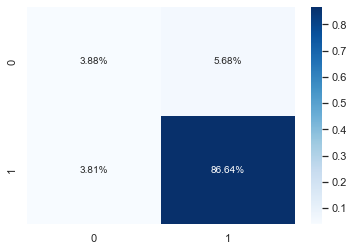

In [43]:
predictions = forest.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [44]:
# from sklearn.tree import export_graphviz# Export as dot file
# import os
# count = 0
# for tree in forest.estimators_:
#     export_graphviz(tree, 
#                 out_file=f'tree{count}.dot', 
#                 feature_names = X_train.columns,
#                 # class_names = y_train.columns,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
#     count += 1

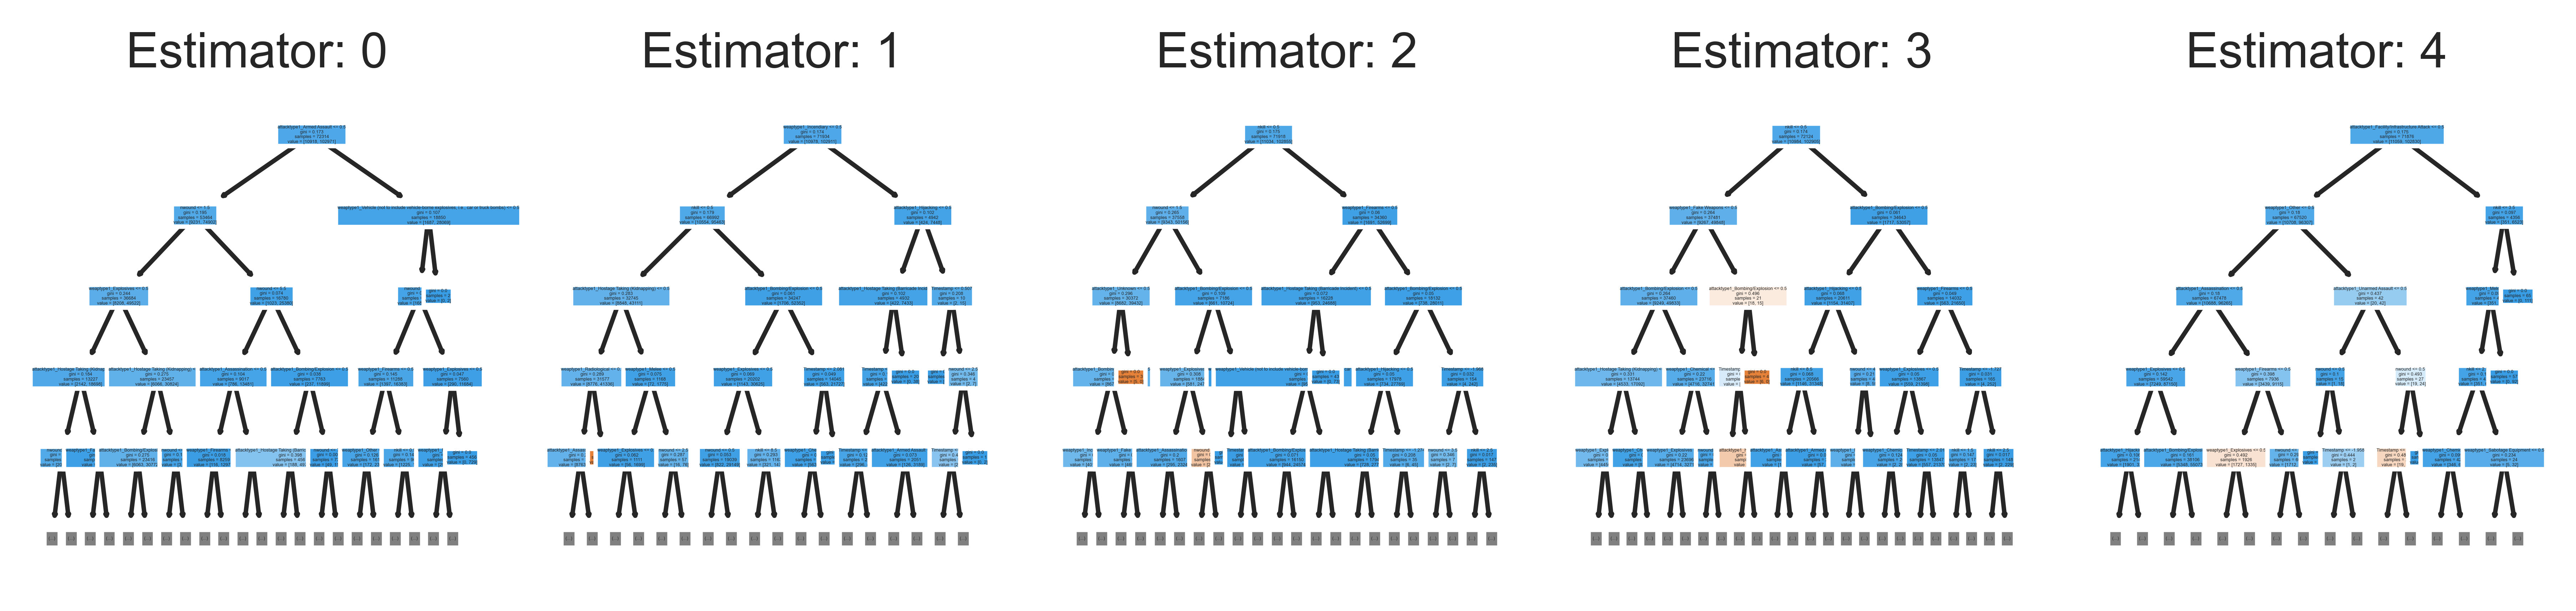

In [51]:
import matplotlib.pyplot as plt
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(forest.estimators_[index],
                   feature_names = X_train.columns, 
                   # class_names=cn,
                   filled = True,
                   max_depth = 4,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

In [46]:
filename = 'ml_model_1_RandomForestClassification.sav'
pickle.dump(forest, open(filename, 'wb'))

## ML Model 2: LogisticRegression

In [186]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [187]:
X_train.columns

Index(['nkill', 'Timestamp', 'nwound', 'weaptype1_Biological',
       'weaptype1_Chemical', 'weaptype1_Explosives', 'weaptype1_Fake Weapons',
       'weaptype1_Firearms', 'weaptype1_Incendiary', 'weaptype1_Melee',
       'weaptype1_Other', 'weaptype1_Radiological',
       'weaptype1_Sabotage Equipment',
       'weaptype1_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'attacktype1_Armed Assault', 'attacktype1_Assassination',
       'attacktype1_Bombing/Explosion',
       'attacktype1_Facility/Infrastructure Attack', 'attacktype1_Hijacking',
       'attacktype1_Hostage Taking (Barricade Incident)',
       'attacktype1_Hostage Taking (Kidnapping)',
       'attacktype1_Unarmed Assault', 'attacktype1_Unknown'],
      dtype='object')

[[  326  2395]
 [  158 25594]]
              precision    recall  f1-score   support

         0.0       0.67      0.12      0.20      2721
         1.0       0.91      0.99      0.95     25752

    accuracy                           0.91     28473
   macro avg       0.79      0.56      0.58     28473
weighted avg       0.89      0.91      0.88     28473



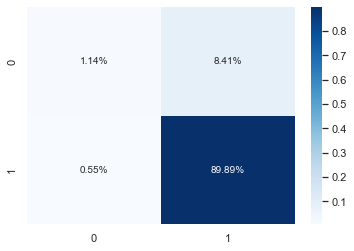

In [188]:
predictions = logreg.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

Looks like the recall is quite bad for values indicated as 0 (unsuccessful attacks). It's predicting many unsuccessful attacks as successful.

What about if we used less features? We will use 5 next.

In [189]:
filename = 'ml_model_2_LogReg.sav'
pickle.dump(logreg, open(filename, 'wb'))


<font color='blue'>Okay, not to be fooled by the score and accuracy (a stunning 0.91), when we first obtained the predictions we were a little scarred. Mainly because we kept scratching our heads at getting a model that was unable to predict 0. Delving deeper into the why, we realised that our dataset had a 10:1 ratio of success to failed outcome. Therefore the predictions probability for the 1 category was way higher than the 0 category as we can see that logreg.predict_proba(X_test) mostly gave us probabilities on the right hand side and collections.Counter(predictions) giving us all 1.</font>
<br><br>
<font color='blue'>
Hence from here, we conclude that LOG REG models go according to a graph and would output values that are most likely to happen (AKA 1) therefore we obtained all 1s. Therefore, log reg model is not a good model to use for this prediction, and we will continue to find out other ways to obtain the answer to our question.</font>

## ML Model 3: KNNClassification

#### Attempt 1: (2 neighbours)

In [56]:
# df1_reduced = df1[sorted_features_set[:3] + ['success']]

In [57]:
# reduced_columns = [
#     # 'Month',
#     'weaptype1',
#     # 'Year',
#     # 'targtype1',
#     # 'Day',
#     # 'targsubtype1',
#     'attacktype1',
#     # 'region',
#     # 'natlty1',
#     # 'country'
# ]

In [58]:
# df1_reduced = pd.get_dummies(df1_reduced, columns=reduced_columns)

In [59]:
# X = df_reduced.drop('success', axis=1)
# y = df_reduced['success']

In [60]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
nb = KNN(n_neighbors=2)
nb.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

[[ 1505  1216]
 [ 2778 22974]]
              precision    recall  f1-score   support

         0.0       0.35      0.55      0.43      2721
         1.0       0.95      0.89      0.92     25752

    accuracy                           0.86     28473
   macro avg       0.65      0.72      0.67     28473
weighted avg       0.89      0.86      0.87     28473



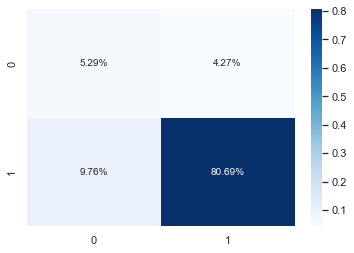

In [62]:
predictions = nb.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

Using a different model appears to have partially solved the issue of recall, and percentage of correctly predicted 0s is higher. However, the precision of both 0 and 1 values, as well as the recall of 1s has decreased. 

In [63]:
filename = 'ml_model_3_KNN_1.sav'
pickle.dump(nb, open(filename, 'wb'))

#### Attempt 2: (7 neighbours)

In [64]:
nb = KNN(n_neighbors=7)
nb.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

[[  915  1806]
 [  421 25331]]
              precision    recall  f1-score   support

         0.0       0.68      0.34      0.45      2721
         1.0       0.93      0.98      0.96     25752

    accuracy                           0.92     28473
   macro avg       0.81      0.66      0.70     28473
weighted avg       0.91      0.92      0.91     28473



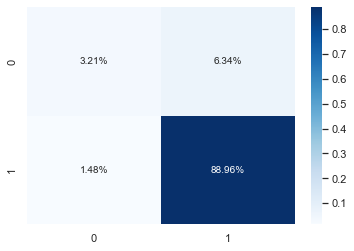

In [65]:
predictions = nb.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [66]:
filename = 'ml_model_3_KNN_2.sav'
pickle.dump(nb, open(filename, 'wb'))

## ML Model 4: LinearSVCModel
With a dash of balanced classweight. Doing a little penalization

#### Attempt 1: Non-weighted

In [67]:
lsvc = LinearSVC(verbose=0)
lsvc.fit(X_train, y_train)

C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

[[  273  2448]
 [  106 25646]]
              precision    recall  f1-score   support

         0.0       0.72      0.10      0.18      2721
         1.0       0.91      1.00      0.95     25752

    accuracy                           0.91     28473
   macro avg       0.82      0.55      0.56     28473
weighted avg       0.89      0.91      0.88     28473



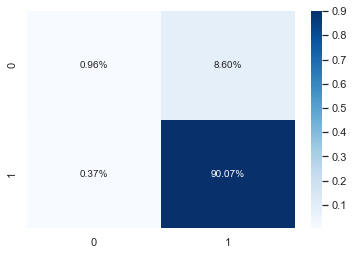

In [68]:
predictions = lsvc.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [69]:
filename = 'ml_model_4_LSVC_1.sav'
pickle.dump(lsvc, open(filename, 'wb'))

#### Attempt 2: Weighted

In [70]:
weights = {0: 85, 1: 15}
lsvc = LinearSVC(verbose=0, class_weight=weights)
lsvc.fit(X_train, y_train)

C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight={0: 85, 1: 15})

[[  810  1911]
 [ 1919 23833]]
              precision    recall  f1-score   support

         0.0       0.30      0.30      0.30      2721
         1.0       0.93      0.93      0.93     25752

    accuracy                           0.87     28473
   macro avg       0.61      0.61      0.61     28473
weighted avg       0.87      0.87      0.87     28473



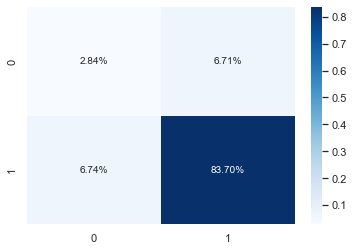

In [71]:
predictions = lsvc.predict(X_test)
c_matrix = metrics.confusion_matrix(y_test, predictions)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, predictions))

In [72]:
filename = 'ml_model_4_LSVC_2.sav'
pickle.dump(lsvc, open(filename, 'wb'))

## DL Model #5: Neural Networks

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [450]:
# define the model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/20
7152/7152 - 7s - loss: 0.2504 - accuracy: 0.9194 - 7s/epoch - 979us/step
Epoch 2/20
7152/7152 - 7s - loss: 0.2287 - accuracy: 0.9243 - 7s/epoch - 932us/step
Epoch 3/20
7152/7152 - 6s - loss: 0.2273 - accuracy: 0.9246 - 6s/epoch - 875us/step
Epoch 4/20
7152/7152 - 7s - loss: 0.2263 - accuracy: 0.9245 - 7s/epoch - 913us/step
Epoch 5/20
7152/7152 - 7s - loss: 0.2262 - accuracy: 0.9246 - 7s/epoch - 951us/step
Epoch 6/20
7152/7152 - 7s - loss: 0.2258 - accuracy: 0.9246 - 7s/epoch - 930us/step
Epoch 7/20
7152/7152 - 7s - loss: 0.2251 - accuracy: 0.9245 - 7s/epoch - 936us/step
Epoch 8/20
7152/7152 - 6s - loss: 0.2250 - accuracy: 0.9243 - 6s/epoch - 882us/step
Epoch 9/20
7152/7152 - 7s - loss: 0.2252 - accuracy: 0.9244 - 7s/epoch - 931us/step
Epoch 10/20
7152/7152 - 6s - loss: 0.2258 - accuracy: 0.9244 - 6s/epoch - 902us/step
Epoch 11/20
7152/7152 - 6s - loss: 0.2247 - accuracy: 0.9244 - 6s/epoch - 877us/step
Epoch 12/20
7152/7152 - 6s - loss: 0.2245 - accuracy: 0.9244 - 6s/epoch - 

In [451]:
filename = 'dl_model_5_NN_20.sav'
pickle.dump(lsvc, open(filename, 'wb'))

In [452]:
predictions = model.predict(X_test)
pred_b = np.round(predictions).astype(int)

In [453]:
np.unique(pred_b, return_counts=True)

(array([0, 1]), array([  893, 27712], dtype=int64))

[[  751  2026]
 [  142 25686]]
              precision    recall  f1-score   support

         0.0       0.84      0.27      0.41      2777
         1.0       0.93      0.99      0.96     25828

    accuracy                           0.92     28605
   macro avg       0.88      0.63      0.68     28605
weighted avg       0.92      0.92      0.91     28605



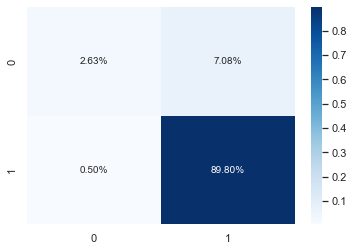

In [454]:
c_matrix = metrics.confusion_matrix(y_test, pred_b)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, pred_b))

In [79]:
weights = {0: 85, 1: 15}

In [80]:
# define the model
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=2, class_weight=weights)

Epoch 1/20
7119/7119 - 8s - loss: 11.3618 - accuracy: 0.7703 - 8s/epoch - 1ms/step
Epoch 2/20
7119/7119 - 7s - loss: 9.9698 - accuracy: 0.7661 - 7s/epoch - 1ms/step
Epoch 3/20
7119/7119 - 7s - loss: 9.8353 - accuracy: 0.7648 - 7s/epoch - 1ms/step
Epoch 4/20
7119/7119 - 8s - loss: 9.8374 - accuracy: 0.7625 - 8s/epoch - 1ms/step
Epoch 5/20
7119/7119 - 8s - loss: 9.7464 - accuracy: 0.7651 - 8s/epoch - 1ms/step
Epoch 6/20
7119/7119 - 7s - loss: 9.7724 - accuracy: 0.7661 - 7s/epoch - 1ms/step
Epoch 7/20
7119/7119 - 7s - loss: 9.7383 - accuracy: 0.7643 - 7s/epoch - 1ms/step
Epoch 8/20
7119/7119 - 7s - loss: 9.6908 - accuracy: 0.7660 - 7s/epoch - 1ms/step
Epoch 9/20
7119/7119 - 7s - loss: 9.6786 - accuracy: 0.7653 - 7s/epoch - 1ms/step
Epoch 10/20
7119/7119 - 8s - loss: 9.6826 - accuracy: 0.7648 - 8s/epoch - 1ms/step
Epoch 11/20
7119/7119 - 8s - loss: 9.6718 - accuracy: 0.7613 - 8s/epoch - 1ms/step
Epoch 12/20
7119/7119 - 8s - loss: 9.6905 - accuracy: 0.7670 - 8s/epoch - 1ms/step
Epoch 13/20


In [82]:
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 78.09


In [83]:
predictions = model.predict(X_test)

In [84]:
pred_b = np.round(predictions).astype(int)

In [85]:
pred_b

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [86]:
predictions

array([[0.01564839],
       [0.03139141],
       [0.9783295 ],
       ...,
       [0.47543332],
       [0.82155526],
       [0.9712704 ]], dtype=float32)

In [87]:
np.unique(pred_b, return_counts=True)

(array([0, 1]), array([ 7524, 20949], dtype=int64))

[[ 2003   718]
 [ 5521 20231]]
              precision    recall  f1-score   support

         0.0       0.27      0.74      0.39      2721
         1.0       0.97      0.79      0.87     25752

    accuracy                           0.78     28473
   macro avg       0.62      0.76      0.63     28473
weighted avg       0.90      0.78      0.82     28473



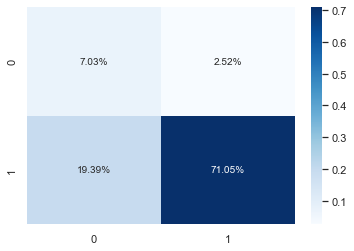

In [88]:
c_matrix = metrics.confusion_matrix(y_test, pred_b)
print(c_matrix)
# sns.heatmap(c_matrix, annot=True, cmap='Blues')
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, fmt='.2%', cmap='Blues')
print(classification_report(y_test, pred_b))

In [448]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                240       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


## Data cleaning with selected features

From our feature analysis with Random Forests, we have found the top 12 variables that contribute to the dataset.

In [89]:
sorted_features_set[:12]

['nkill',
 'Timestamp',
 'attacktype1',
 'nwound',
 'weaptype1',
 'suicide',
 'Month',
 'Year',
 'targtype1',
 'Day',
 'crit3',
 'targsubtype1']

In [90]:
df.shape

(181541, 136)

Although we used the text version of the features/variables earlier, we will make use of the non-text version here (applicable for weaptype1, attacktype1, targsubtype1, targtype1) as they hold basically the same data, but in another format.

In [91]:
df_small = df[sorted_features_set[:12] + ["success"]]

In [92]:
df_small.isnull().sum()

nkill           10165
Timestamp           0
attacktype1         0
nwound          16167
weaptype1           0
suicide             0
Month               0
Year                0
targtype1           0
Day                 0
crit3               0
targsubtype1    11051
success             1
dtype: int64

In [93]:
df_small.dropna(axis=0, inplace=True)

C:\Users\nghoc\AppData\Local\Temp\ipykernel_10892\1898931651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.dropna(axis=0, inplace=True)


In [94]:
df_small.isnull().sum()

nkill           0
Timestamp       0
attacktype1     0
nwound          0
weaptype1       0
suicide         0
Month           0
Year            0
targtype1       0
Day             0
crit3           0
targsubtype1    0
success         0
dtype: int64

In [95]:
df_small['weaptype1'].value_counts() # To remove 13

6     78912
5     50333
13    11385
8      9811
9      3242
2       292
11      131
10      131
12      101
7        33
1        30
3        14
Name: weaptype1, dtype: int64

In [96]:
df_small['attacktype1'].value_counts() # To remove 9

3    75082
2    37386
1    17157
7     9187
6     7458
9     5889
8      878
5      819
4      559
Name: attacktype1, dtype: int64

In [97]:
df_small['targtype1'].value_counts() #To remove 20 (no 20s)

14    37915
4     23728
3     22808
2     19856
1     16374
19     6259
21     5274
15     4035
8      4023
7      3250
17     2574
10     2518
22     1747
6      1188
12      793
16      780
18      401
9       272
11      264
5       251
13      105
Name: targtype1, dtype: int64

In [98]:
df_small = df_small[df_small["weaptype1"] != 13]
df_small = df_small[df_small["attacktype1"] != 9]
df_small = df_small[df_small["targtype1"] != 20]

In [99]:
df_small.shape

(143022, 13)

Tbh the number of points is not changed much - earlier its 142362 compared to now 143022. Doesn't really make much of a difference.

In [100]:
df_small['success'].value_counts()

1.0    129226
0.0     13796
Name: success, dtype: int64

### Weighted logistic regression with increasing number of features

In [340]:
weights = {0: 85, 1: 15}

In [341]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [342]:
df_reduced = df_small[sorted_features_set[:1] + ['success']]

In [343]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [345]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [346]:
predictions = wlogreg.predict(X_test)

In [347]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[    0  2777]
 [    0 25828]]


<AxesSubplot:>

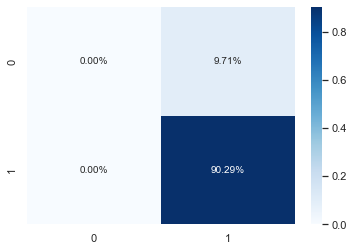

In [348]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [349]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2777
         1.0       0.90      1.00      0.95     25828

    accuracy                           0.90     28605
   macro avg       0.45      0.50      0.47     28605
weighted avg       0.82      0.90      0.86     28605



C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [350]:
# With 2

In [351]:
weights = {0: 85, 1: 15}

In [352]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [353]:
df_reduced = df_small[sorted_features_set[:2] + ['success']]

In [354]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [356]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [357]:
predictions = wlogreg.predict(X_test)

In [358]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[    0  2777]
 [    0 25828]]


<AxesSubplot:>

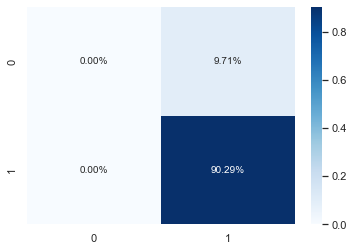

In [359]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [360]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2777
         1.0       0.90      1.00      0.95     25828

    accuracy                           0.90     28605
   macro avg       0.45      0.50      0.47     28605
weighted avg       0.82      0.90      0.86     28605



C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nghoc\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
# With 3

In [362]:
weights = {0: 85, 1: 15}

In [363]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [364]:
df_reduced = df_small[sorted_features_set[:3] + ['success']]

In [365]:
reduced_columns = [
    # 'Month',
    # 'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [366]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [367]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [369]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [370]:
predictions = wlogreg.predict(X_test)

In [371]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[  859  1918]
 [ 2295 23533]]


<AxesSubplot:>

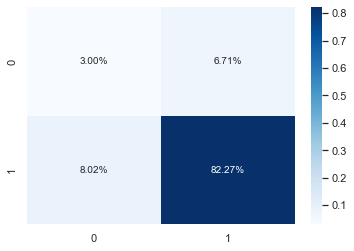

In [372]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [373]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.27      0.31      0.29      2777
         1.0       0.92      0.91      0.92     25828

    accuracy                           0.85     28605
   macro avg       0.60      0.61      0.60     28605
weighted avg       0.86      0.85      0.86     28605



In [387]:
# With 4

In [388]:
weights = {0: 85, 1: 15}

In [389]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [390]:
df_reduced = df_small[sorted_features_set[:4] + ['success']]

In [391]:
reduced_columns = [
    # 'Month',
    # 'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [392]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [393]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [395]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [396]:
predictions = wlogreg.predict(X_test)

In [397]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[  834  1943]
 [ 2320 23508]]


<AxesSubplot:>

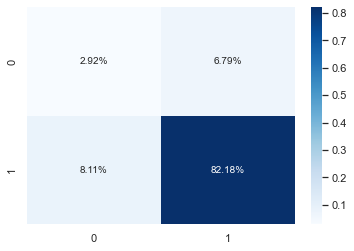

In [398]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [399]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.26      0.30      0.28      2777
         1.0       0.92      0.91      0.92     25828

    accuracy                           0.85     28605
   macro avg       0.59      0.61      0.60     28605
weighted avg       0.86      0.85      0.86     28605



In [436]:
weights = {0: 85, 1: 15}

In [437]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [438]:
df_reduced = df_small[sorted_features_set[:5] + ['success']]

In [439]:
reduced_columns = [
    # 'Month',
    'weaptype1',
    # 'Year',
    # 'targtype1',
    # 'Day',
    # 'targsubtype1',
    'attacktype1',
    # 'region',
    # 'natlty1',
    # 'country'
]

In [440]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [441]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [443]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [444]:
predictions = wlogreg.predict(X_test)

In [445]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[  854  1923]
 [ 2389 23439]]


<AxesSubplot:>

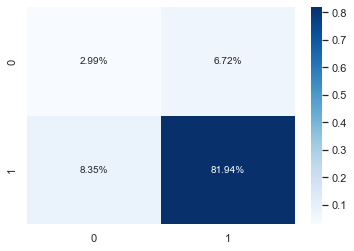

In [446]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [447]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.26      0.31      0.28      2777
         1.0       0.92      0.91      0.92     25828

    accuracy                           0.85     28605
   macro avg       0.59      0.61      0.60     28605
weighted avg       0.86      0.85      0.85     28605



In [412]:
# What if we just use categorical data?

In [413]:
reduced_columns = [
    'Month',
    'weaptype1',
    'Year',
    'targtype1',
    'Day',
    'targsubtype1',
    'attacktype1',
]

In [425]:
weights = {0: 85, 1: 15}

In [426]:
wlogreg = LogisticRegression(class_weight=weights, solver="lbfgs", max_iter=1000)

In [427]:
df_reduced = df_small[reduced_columns + ['success']]

In [428]:
df_reduced = pd.get_dummies(df_reduced, columns=reduced_columns)

In [429]:
X = df_reduced.drop('success', axis=1)
y = df_reduced['success']

In [430]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [431]:
wlogreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 85, 1: 15}, max_iter=1000)

In [432]:
predictions = wlogreg.predict(X_test)

In [433]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)

[[ 1127  1650]
 [ 3323 22505]]


<AxesSubplot:>

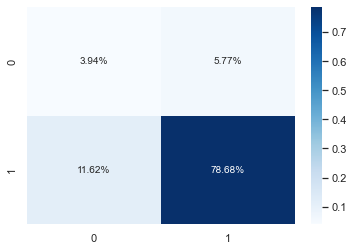

In [434]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [435]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.25      0.41      0.31      2777
         1.0       0.93      0.87      0.90     25828

    accuracy                           0.83     28605
   macro avg       0.59      0.64      0.61     28605
weighted avg       0.87      0.83      0.84     28605

